# Data Example

Let's see if we can load an example and get Claude to give some synthetic data for it

In [1]:
import joblib

# Example data
x = joblib.load('example.joblib')

x

In the image, a man and a woman are taking a selfie together in front of a building. The woman is wearing sunglasses and holding a selfie stick, while the man is wearing a white hat and is standing close to the woman. The woman is smiling while taking the picture. The background consists of a white building, and the woman has a black cellphone in her hand. There are various bags visible in the scene, such as a backpack near


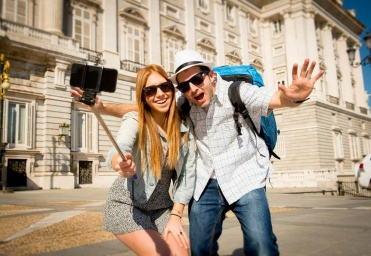

In [6]:
from IPython.display import Image

print(x[0])
display(x[1])

In [3]:
from claude_wrapper import ClaudeOneShot

In [15]:
chat = ClaudeOneShot()

system = "Given a description of an image, make some questions that \
could only be answered by someone that is able to see the image but not the caption. \
Please follow a strict format in your response where you give the questions as a list i.e. [{question 1}, {question 2}] with no need for numbering"
res = chat(system, x[0])

def postproc(res):
    new = res[res.find("[")+1:res.find("]")].split("?,")
    new = [new_i.strip() for new_i in new]
    return new

res = postproc(res)

In [16]:
res

["What color is the man's hat",
 'Is the woman wearing sunglasses or regular glasses',
 'What color is the building in the background',
 'What object is the woman holding to take the selfie',
 "What color is the woman's cellphone?"]

# SAM and Depth Estimation

Now we will try to incorporate segment anything model and use its outputs for giving further context to claude. First we'll do SAM

In [119]:
from transformers import pipeline
import requests
from PIL import Image

# Example image from HF
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

In [126]:
sam_pipe = pipeline("mask-generation", model = "facebook/sam-vit-huge", device = 'cuda')

config.json: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.57k/6.57k [00:00<00:00, 3.31MB/s]
C:\Users\smati\miniconda3\envs\baseml\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\smati\.cache\huggingface\hub\models--facebook--sam-vit-huge. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.m

In [127]:
res = sam_pipe(raw_image, points_per_batch = 64)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 4.29 GiB is allocated by PyTorch, and 931.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
masks = res['masks']

In [ ]:
import matplotlib.pyplot as plt

def generate_colors(n_colors):
    # Use the 'jet' colormap
    cmap = plt.cm.jet
    # Generate colors from the colormap
    colors = [cmap(i/n_colors)[:3] for i in range(n_colors)]
    # Convert colors to 3-tuples in the range 0-255 (for RGB)
    colors = [(int(r*255), int(g*255), int(b*255)) for r, g, b in colors]
    return colors

In [ ]:
import numpy as np
from PIL import Image

# Create a blank image with the same dimensions as the masks and 3 color channels (RGB)
height, width = masks[0].shape
image = np.zeros((height, width, 3), dtype=np.uint8)

# Define a list of colors, one for each mask
colors = generate_colors(len(masks))

# Overlay each mask onto the image with its respective color
for mask, color in zip(masks, colors):
    for c in range(3):  # Iterate over the color channels
        image[:,:,c] = np.where(mask, color[c], image[:,:,c])

# Convert the resulting image to a PIL Image
pil_image = Image.fromarray(image)

In [ ]:
display(raw_image)

In [ ]:
display(pil_image)

# Next Try YOLO fast

In [54]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 19.5MB/s]


In [56]:
res = model(x[1])


0: 448x640 2 persons, 1 traffic light, 28.0ms
Speed: 4.0ms preprocess, 28.0ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


In [69]:
print(res[0].boxes.xywh)
print(res[0].boxes.cls)
print(res[0].names)

tensor([[248.1974, 150.7912, 151.7559, 201.2637],
        [140.2776, 159.7103, 103.5045, 190.8880],
        [ 93.8914,  78.3539,  48.2739,  31.6519]], device='cuda:0')
tensor([0., 0., 9.], device='cuda:0')
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'd